In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
import networkx as nx
%matplotlib inline

In [2]:
import itertools
import random
import statistics
from itertools import islice


In [3]:
from scipy.stats import power_divergence

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from network import *

In [6]:
import math

In [7]:
from loaders import *

In [8]:
from IPython.core.display import Image, display

In [9]:

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [10]:
def plot_labels(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [11]:
def plot_dict(stat, xlbl, ylbl):
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [12]:
def plot_weighet_graph(graph, weights=None):
    if weights == None:
        weights = [1] * len(graph.nodes())
    
    nodesize = [weights[v] * 10000 for v in graph]
    try:
        pos=nx.nx_agraph.graphviz_layout(graph)
    except:
        pos=nx.spring_layout(graph,iterations=20)
    nx.draw(graph, node_size=nodesize, pos=pos, node_color="w")
    nx.draw_networkx_labels(graph, pos)
    

In [13]:
def get_time_seriece(weights_per_period, node):
    return [weights.get(node, 0.0) for weights in weights_per_period]

In [14]:
def get_weights_in_period(file ,start, end):
    coauthorNetwork = load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    (auth_subgraph, auth_weights, auth_sorted_nodes) = calc_pagerank(coauthorNetwork.gr)
    (cite_subgraph, cite_weights, cite_sorted_nodes) = calc_pagerank(coauthorNetwork.cgr)
    print("Top researchers", cite_sorted_nodes[:10])
    return ((auth_weights, auth_sorted_nodes), (cite_weights, cite_sorted_nodes) )

In [15]:
coauthorNetwork = CoauthorNetwork.load_with_loader("./data/out_test.txt", parse_dataset_file);


#run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")


Uniq authors: 42619


In [16]:
'''
coauthorNetwork.gen_components()
coauthorNetwork.analize_component()
coauthorNetwork.print_info_component()
'''

'\ncoauthorNetwork.gen_components()\ncoauthorNetwork.analize_component()\ncoauthorNetwork.print_info_component()\n'

In [17]:
def calculate_cite_author_quantity_distribution(file, start, end):
    coauthor_network = CoauthorNetwork.load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    dist = coauthor_network.calc_coauthor_cite_distribution()
    plot_pairs(dist[0], "number of coauthors", "article quantity")
    plot_pairs(dist[1], "number of citations", "article quantity")

# calculate_cite_author_quantity_distribution("./data/out_test.txt", 2000, 2001)

In [18]:
# Analyse time series
'''
file = "./data/out_test.txt"

coauthorNetwork = load_with_loader(file, parse_dataset_file)
nodes_count = len(coauthorNetwork.gr.nodes())

train_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]
test_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]

weights_per_period = []
weights_per_period.append(get_weights_in_period(file, 1990, 1995))
weights_per_period.append(get_weights_in_period(file, 1995, 2000))
weights_per_period.append(get_weights_in_period(file, 2000, 2005))
weights_per_period.append(get_weights_in_period(file, 2005, 2010))

weights_per_period_auth = [ w[0][0] for w in weights_per_period ]
weights_per_period_cite = [ w[1][0] for w in weights_per_period ]

x_train = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

# print("x_train", x_train[0:10])
# print("y_train", y_train[0:10])
x_test = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_test = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)

for pair in zip(lm.predict(x_test)[0:10], y_test[0:10]):
    print(pair)
    
# print(lm.predict(x_test)[0:10])
# print(y_test[0:10])
'''


'\nfile = "./data/out_test.txt"\n\ncoauthorNetwork = load_with_loader(file, parse_dataset_file)\nnodes_count = len(coauthorNetwork.gr.nodes())\n\ntrain_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]\ntest_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]\n\nweights_per_period = []\nweights_per_period.append(get_weights_in_period(file, 1990, 1995))\nweights_per_period.append(get_weights_in_period(file, 1995, 2000))\nweights_per_period.append(get_weights_in_period(file, 2000, 2005))\nweights_per_period.append(get_weights_in_period(file, 2005, 2010))\n\nweights_per_period_auth = [ w[0][0] for w in weights_per_period ]\nweights_per_period_cite = [ w[1][0] for w in weights_per_period ]\n\nx_train = [get_time_seriece(weights_per_period_auth, author) \n           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]\ny_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]\n\n# print("x_train", x_train[0:10])\n# print(

In [19]:
coauthorNetwork = CoauthorNetwork.load_with_loader("./data/out_test.txt", parse_dataset_file)
stats = coauthorNetwork.top_authors_cite_coauth_stat()

Uniq authors: 42619


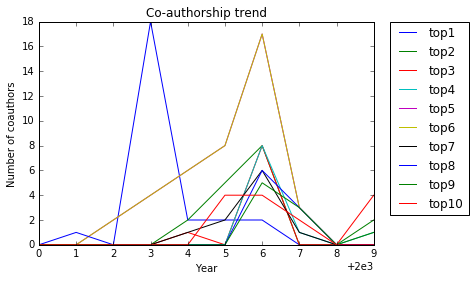

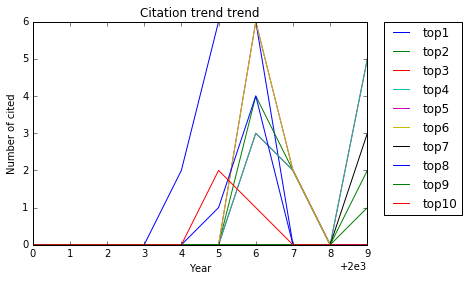

In [20]:
def render_stat(stat):
    for idx, author in enumerate(stat):
        rg = range(2000, 2010)
        author_line = [author.get(year, 0) for year in rg]
        plt.plot(list(rg), author_line, label="top" + str(idx + 1) ) 

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
plot_labels("Year", "Number of coauthors", "Co-authorship trend")
render_stat(stats[0])

plot_labels("Year", "Number of cited", "Citation trend trend")
render_stat(stats[1])
